#import library

In [29]:
import os
import time
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from pathlib import Path
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, make_scorer, accuracy_score 

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#get data

In [123]:
data_path = '/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/'
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/train.csv')
img_train = glob(data_path + 'train/*.jpg')

In [77]:
print('dimensions: ', df_train.shape)
print('column names: ', df_train.columns.values.tolist())

dimensions:  (9912, 14)
column names:  ['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity']


In [6]:
print('train_jpg is of type ',type(img_train), ' and length ', len(img_train))
print('train_jpg list 1st 3 elements: ', img_train[0:3], '\n')

train_jpg is of type  <class 'list'>  and length  9912
train_jpg list 1st 3 elements:  ['/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/train/e8582039b8159874938fba571440fec4.jpg', '/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/train/e375d5fed8249e56e71dbc6676405486.jpg', '/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/train/e668a48b676a06257606491406be9733.jpg'] 



#explore metadata

In [7]:
df_train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


***distribution of Pawpularity Scores***

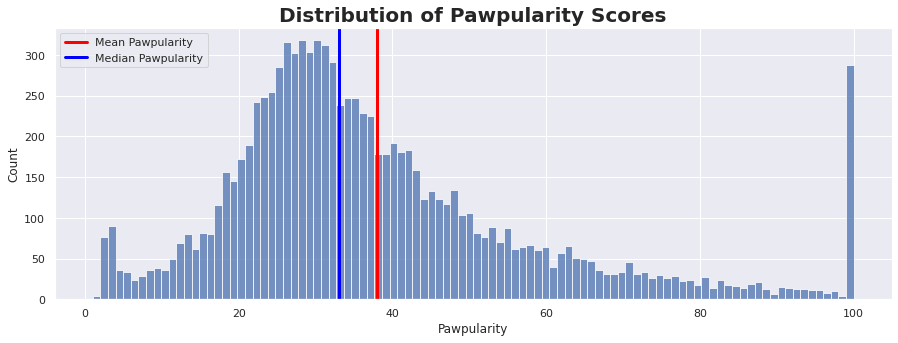

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure()
sns.histplot(data=df_train, x='Pawpularity', bins=100)
plt.axvline(df_train['Pawpularity'].mean(), c='red', ls='-', lw=3, label='Mean Pawpularity')
plt.axvline(df_train['Pawpularity'].median(),c='blue',ls='-',lw=3, label='Median Pawpularity')
plt.title('Distribution of Pawpularity Scores', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

***statistical description of pawpularity scores***

In [ ]:
df_train[['Pawpularity']].describe()

,Pawpularity
count,9912.000000
mean,38.039044
std,20.591990
min,1.000000
25%,25.000000
50%,33.000000
75%,46.000000
max,100.000000


#Data Visualization

***metadata visualization***

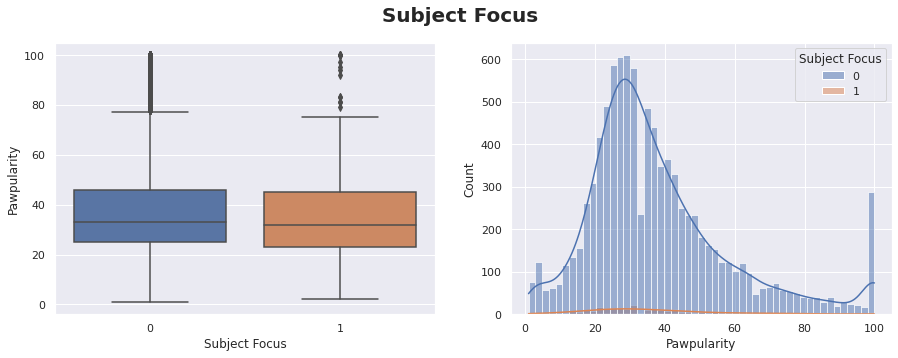

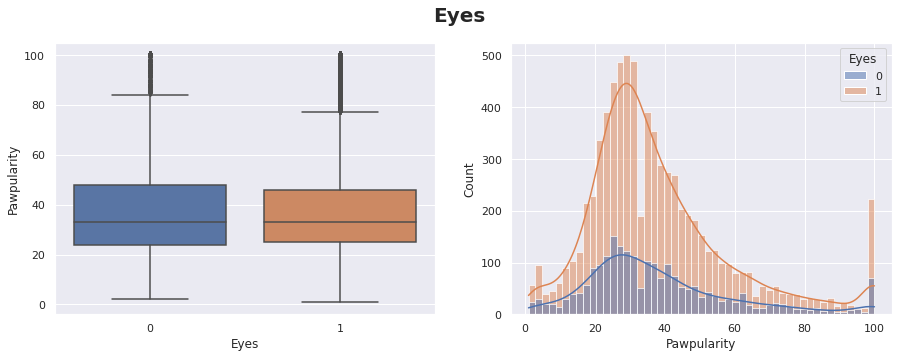

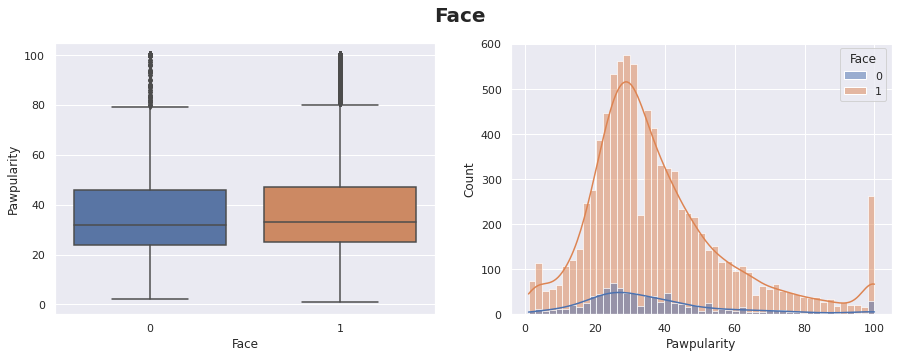

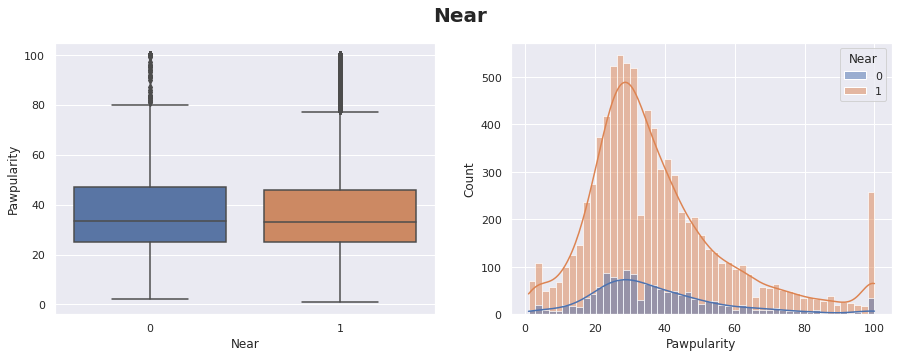

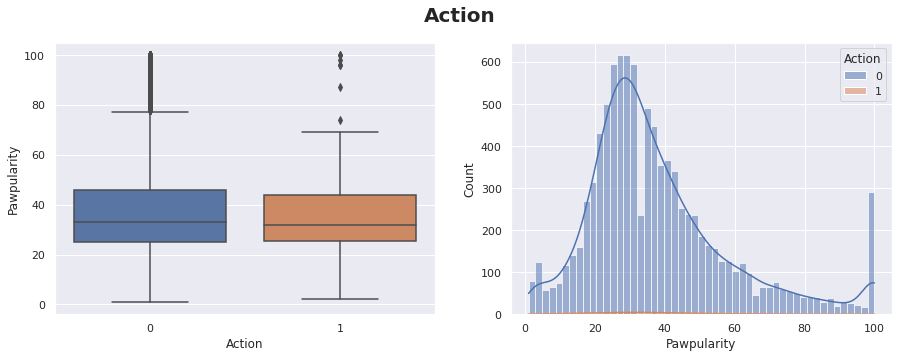

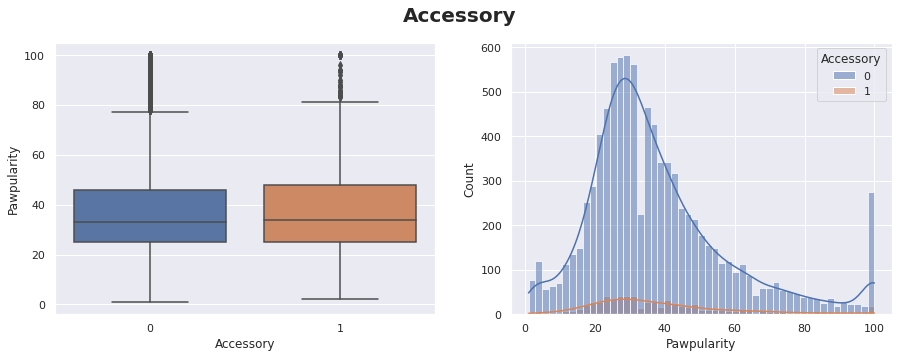

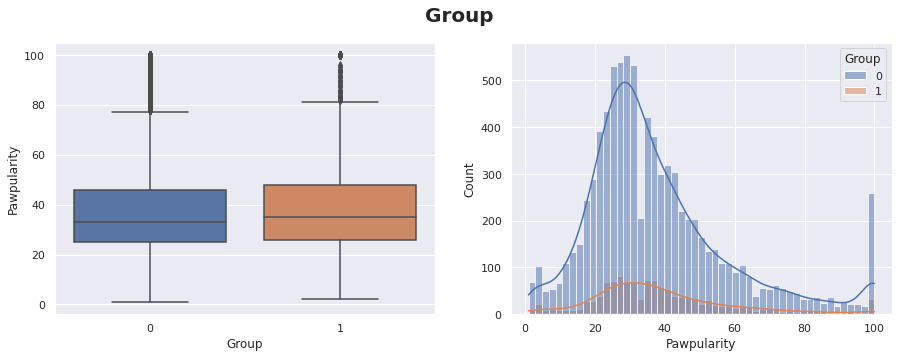

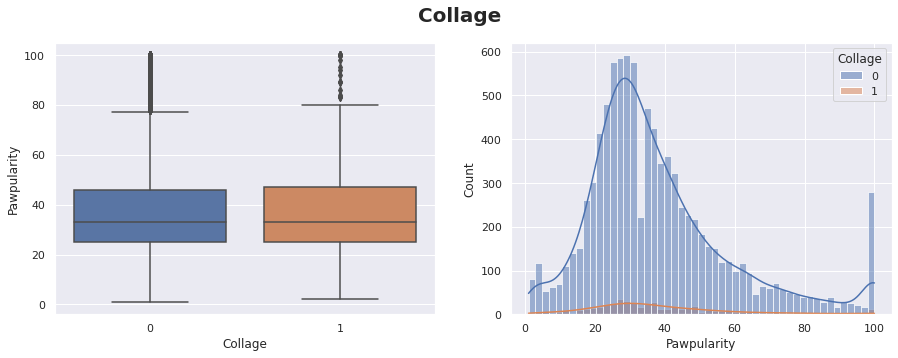

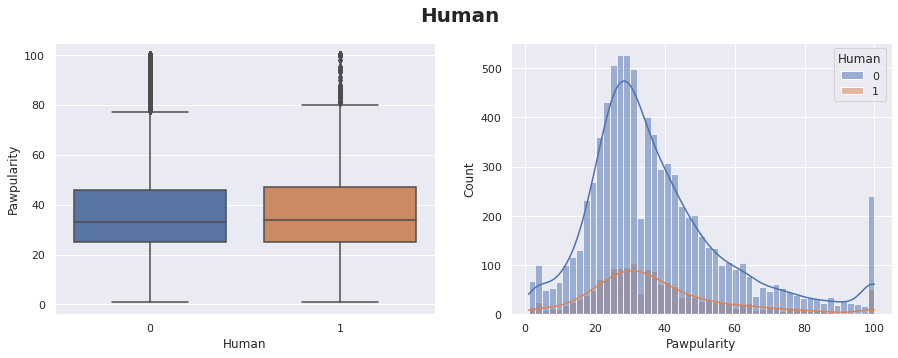

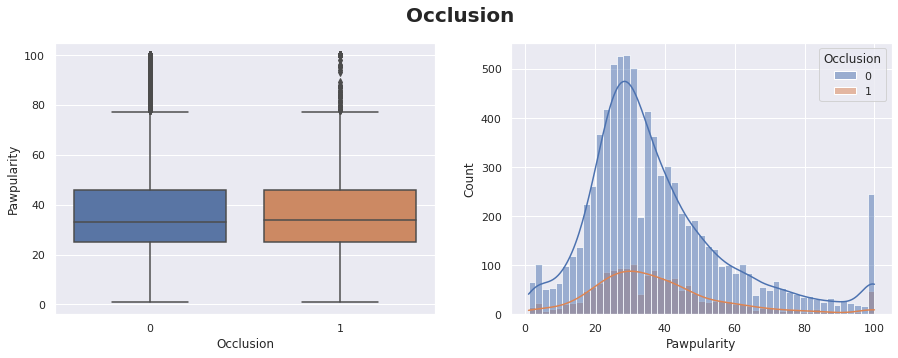

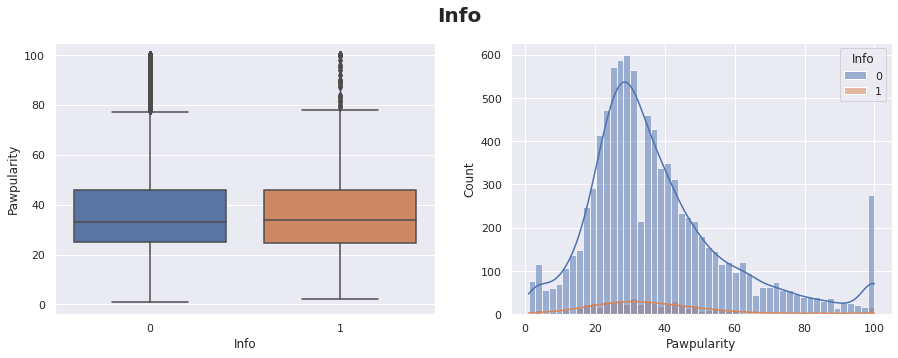

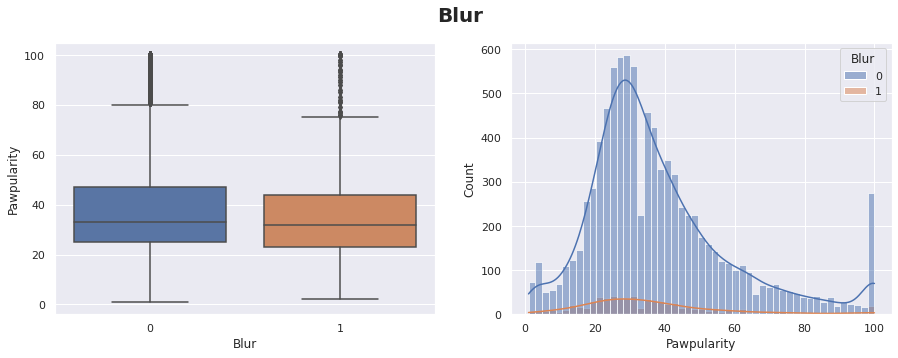

In [ ]:
features = df_train.columns.values.tolist()

#for each of the feature variables, doesn't include Id and Pawpularity by using [1:-1]
#show a boxplot and distribution plot against pawpularity
for variable in features[1:-1]:
    fig, ax = plt.subplots(1,2)
    sns.boxplot(data=df_train, x=variable, y='Pawpularity', ax=ax[0])
    sns.histplot(df_train, x="Pawpularity", hue=variable, kde=True, ax=ax[1])
    plt.suptitle(variable, fontsize=20, fontweight='bold')
    fig.show()

***image visualization***

explore the first 3 images

image 0's dimensions are: (960, 720, 3)


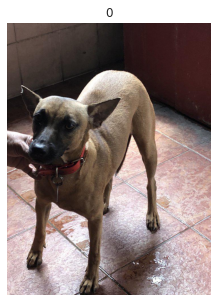

image 1's dimensions are: (960, 720, 3)


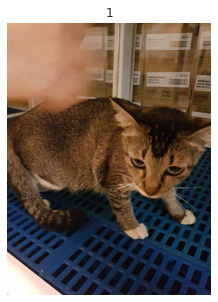

image 2's dimensions are: (720, 405, 3)


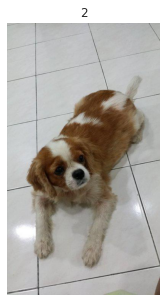

In [ ]:
for x in range(3):
    #this loop goes through index of the train_jpg list of filenames: 0,1,2
    image_path = img_train[x]
    #use plt.imread() to read in that image file as an array of numbers between 0-255
    image = plt.imread(image_path) 
    #Let's check the image dimensions
    print("image {}'s dimensions are: {}".format(x,image.shape))
    #then plt.imshow() can display it for you
    plt.imshow(image)
    #title is the index of train_jpg
    plt.title(x) 
    #turn off gridlines
    plt.axis('off')
    #show the image
    plt.show()

pet pictures based on given pawpularity scores.

In [ ]:
id_stem = Path(img_train[0]).stem
print('Original: ', img_train[0])
print('After: ', id_stem)

Original:  /content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/train/e8582039b8159874938fba571440fec4.jpg
After:  e8582039b8159874938fba571440fec4


In [ ]:
def pawpularity_pics(df, num_images, desired_pawpularity, random_state):
    '''The pawpularity_pics() function accepts 4 parameters: df is a dataframe, 
    num_images is the number of images you want displayed, desired_pawpularity 
    is the pawpularity score of pics you want to see, and random state ensures reproducibility.'''
    #how many images to display
    num_images = num_images
    #set the rample state for the sampling for reproducibility
    random_state = random_state
    
    #filter the train_df on the desired_pawpularity and use .sample() to get a sample
    random_sample = df[df["Pawpularity"] == desired_pawpularity].sample(num_images, random_state=random_state).reset_index(drop=True)
    
    #The for loop goes as many loops as specified by the num_images
    for x in range(num_images):
        #start from the id in the dataframe
        image_path_stem = random_sample.iloc[x]['Id']
        root = data_path + 'train/'
        extension = '.jpg'
        image_path = root + str(image_path_stem) + extension
         
        #get the pawpularity to confirm it worked
        pawpularity_by_id = random_sample.iloc[x]['Pawpularity']
    
        #use plt.imread() to read in the image file
        image_array = plt.imread(image_path)
        #make a subplot space that is 1 down and num_images across
        plt.subplot(1, num_images, x+1)
        #title is the pawpularity score from the id
        title = pawpularity_by_id
        plt.title(title) 
        #turn off gridlines
        plt.axis('off')
        #then plt.imshow() can display it for you
        plt.imshow(image_array)
    plt.show()
    plt.close()

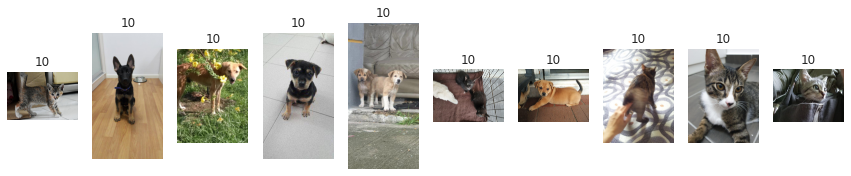

In [ ]:
df = df_train
num_images = 10
desired_pawpularity = 10
random_state = 0
pawpularity_pics(df, num_images, desired_pawpularity, random_state)

In [ ]:
scores = list(range(0, 100))
df = df_train
num_images = 1
random_state = 1

row, col = 10, 10
for i in range(row*col):
  for score in range(1, 101):
    desired_pawpularity = score
    pawpularity_pics(df, num_images, desired_pawpularity, random_state)
    # pawpularity_pics(df = img_train, num_images = 1, desired_pawpularity = score, random_state = 1)  

#Using metadata to create ML models

***split the train, validation, test dataset***

In [ ]:
y = df_train['Pawpularity']
X = df_train.drop(['Id','Pawpularity'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1)

In [ ]:
print('Dimensions: \n x_train:{} \n x_test{} \n x_val{} \n y_train{} \n y_test{} \n y_val{}'
.format(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape))

Dimensions: 
 x_train:(7136, 12) 
 x_test(1983, 12) 
 x_val(793, 12) 
 y_train(7136,) 
 y_test(1983,) 
 y_val(793,)


In [ ]:
x_train.head(2)

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
3333,0,0,1,0,0,1,1,1,0,0,1,1
4518,0,1,1,1,0,0,0,0,0,0,0,0


In [ ]:
y_train.head(2)

3333    37
4518    28
Name: Pawpularity, dtype: int64

#Decision Tree

In [ ]:
criterion = ["squared_error", "absolute_error"]
max_depth = [2, 4, 6, 8, 10, 12]
r_square = []
mse = []
rmse = []
t = []

for c in criterion:
    for m in max_depth:
        t0 = time.time()
        DT = DecisionTreeRegressor(criterion=c, max_depth=m, min_samples_split = 10)
        DT.fit(x_train, y_train)
        t1 = time.time()
        y_predict = DT.predict(x_test)
        training_time = t1 - t0
        r = DT.score(x_train, y_train)
        mean_se = mean_squared_error(y_test, y_predict)
        r_mean_se = math.sqrt(mean_squared_error(y_test, y_predict))
        r_square.append(r)
        mse.append(mean_se)
        rmse.append(r_mean_se)
        t.append(training_time)


d={'criterion':['squared_error','squared_error','squared_error','squared_error','squared_error','squared_error',
                'absolute_error', 'absolute_error','absolute_error','absolute_error','absolute_error','absolute_error'],\
  'max depth':[2, 4, 6, 8, 10, 12,2, 4, 6, 8, 10, 12],\
  'R_Square': r_square,\
  'MSE': mse,\
  'RMSE': rmse,\
  'training time': t}

summary = pd.DataFrame(data=d)
print(summary)

         criterion  max depth  R_Square         MSE       RMSE  training time
0    squared_error          2  0.001525  419.415231  20.479630       0.004101
1    squared_error          4  0.008430  421.028355  20.518975       0.003011
2    squared_error          6  0.015773  425.755288  20.633838       0.003412
3    squared_error          8  0.024052  432.208876  20.789634       0.003737
4    squared_error         10  0.028672  433.203061  20.813531       0.003946
5    squared_error         12  0.030339  433.672652  20.824809       0.004083
6   absolute_error          2 -0.054165  448.685830  21.182205       0.399264
7   absolute_error          4 -0.045737  451.100605  21.239129       0.623066
8   absolute_error          6 -0.039227  452.109808  21.262874       0.722475
9   absolute_error          8 -0.034969  458.653933  21.416207       0.789390
10  absolute_error         10 -0.027440  464.069844  21.542280       0.815328
11  absolute_error         12 -0.025982  464.887922  21.561260  

In [ ]:
DT = DecisionTreeRegressor(max_depth=3, min_samples_split = 10)
start = time.time()
DT.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
y_predict = DT.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
tree_reg_RMSE = math.sqrt(mean_squared_error(y_test, y_predict))
print(f'tree_reg_RMSE: {round(tree_reg_RMSE,3)}')

Training time: 0.005 seconds
tree_reg_RMSE: 20.517


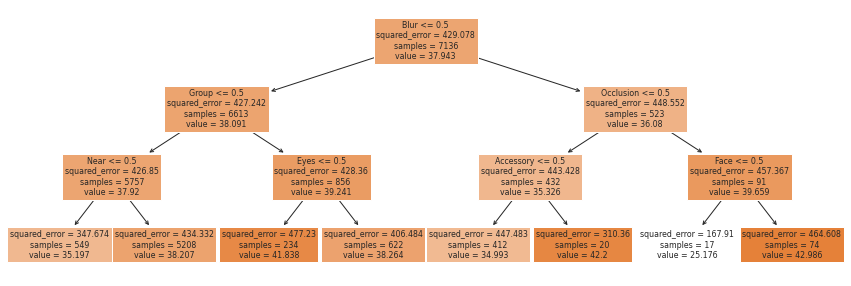

In [ ]:
fig = plt.figure(figsize=(15,5))
plot = tree.plot_tree(DT, feature_names=x_train.columns.values.tolist(), filled=True)

#Random Forest

In [ ]:
n_estimators = [10,50,100,500,1000]
r_square = []
mse = []
rmse = []
t = []
for n in n_estimators:
    t0 = time.time()
    RF = RandomForestRegressor(n_estimators=n, max_depth=5)
    RF.fit(x_train, y_train)
    t1 = time.time()
    y_predict = RF.predict(x_test)
    training_time = t1 - t0
    r = DT.score(x_train, y_train)
    mean_se = mean_squared_error(y_test, y_predict)
    r_mean_se = math.sqrt(mean_squared_error(y_test, y_predict))
    r_square.append(r)
    mse.append(mean_se)
    rmse.append(r_mean_se)
    t.append(training_time)


d={'estimators': n_estimators,\
  'R_Square': r_square,\
  'MSE': mse,\
  'RMSE': rmse,\
  'training time': t}

summary = pd.DataFrame(data=d)
print(summary)

   estimators  R_Square         MSE       RMSE  training time
0          10   0.00546  420.709700  20.511209       0.026089
1          50   0.00546  420.524197  20.506687       0.109597
2         100   0.00546  420.737213  20.511880       0.224049
3         500   0.00546  420.871079  20.515143       1.087209
4        1000   0.00546  420.945686  20.516961       2.171146


#XGBoost

In [ ]:
pip install xgboost==1.4.1

     |████████████████████████████████| 166.7 MB 43 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.0.1
    Uninstalling xgboost-1.0.1:
      Successfully uninstalled xgboost-1.0.1


In [ ]:
# check xgboost version
import xgboost
print(xgboost.__version__)
from xgboost import XGBRegressor

1.0.1


In [ ]:
n_estimators = [10,50,100,500,1000]
r_square = []
mse = []
rmse = []
t = []
for n in n_estimators:
    t0 = time.time()
    model = XGBRegressor(n_estimators=n, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(x_train, y_train)
    t1 = time.time()
    y_predict = model.predict(x_test)
    training_time = t1 - t0
    r = model.score(x_train, y_train)
    mean_se = mean_squared_error(y_test, y_predict)
    r_mean_se = math.sqrt(mean_squared_error(y_test, y_predict))
    r_square.append(r)
    mse.append(mean_se)
    rmse.append(r_mean_se)
    t.append(training_time)


d={'estimators': n_estimators,\
  'R_Square': r_square,\
  'MSE': mse,\
  'RMSE': rmse,\
  'training time': t}

summary = pd.DataFrame(data=d)
print(summary)

   estimators  R_Square         MSE       RMSE  training time
0          10 -0.391165  604.745723  24.591578       0.029209
1          50  0.028842  427.415917  20.674040       0.150501
2         100  0.033477  431.904703  20.782317       0.314677
3         500  0.036628  437.393700  20.913959       1.646448
4        1000  0.036582  439.883410  20.973398       3.242674


#Using image+metadata combination to predict

***get data***

In [124]:
tabular_columns = df_train.columns.drop(['Id', 'Pawpularity']).values.tolist()
image_size = 256 # model1: 299
batch_size = 512 # model1: 128
epochs = 100
AUTO = tf.data.experimental.AUTOTUNE

In [79]:
print(tabular_columns)
print(type(tabular_columns))
print(len(tabular_columns))

['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
<class 'list'>
12


In [ ]:
print(df_train)

                                    Id  Subject Focus  ...  Blur  Pawpularity
0     0007de18844b0dbbb5e1f607da0606e0              0  ...     0           63
1     0009c66b9439883ba2750fb825e1d7db              0  ...     0           42
2     0013fd999caf9a3efe1352ca1b0d937e              0  ...     0           28
3     0018df346ac9c1d8413cfcc888ca8246              0  ...     0           15
4     001dc955e10590d3ca4673f034feeef2              0  ...     0           72
...                                ...            ...  ...   ...          ...
9907  ffbfa0383c34dc513c95560d6e1fdb57              0  ...     1           15
9908  ffcc8532d76436fc79e50eb2e5238e45              0  ...     0           70
9909  ffdf2e8673a1da6fb80342fa3b119a20              0  ...     0           20
9910  fff19e2ce11718548fa1c5d039a5192a              0  ...     0           20
9911  fff8e47c766799c9e12f3cb3d66ad228              0  ...     0           30

[9912 rows x 14 columns]


In [125]:
df_train["file_path"] = df_train.apply(lambda row : data_path + 'train/' + str(row['Id']) + '.jpg', axis=1)

In [ ]:
df_train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/drive/MyDrive/Colab Notebooks/petfind...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/drive/MyDrive/Colab Notebooks/petfind...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/drive/MyDrive/Colab Notebooks/petfind...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/drive/MyDrive/Colab Notebooks/petfind...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/drive/MyDrive/Colab Notebooks/petfind...


In [126]:
y = df_train['Pawpularity']
X = df_train.drop(['Id'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1)

In [ ]:
print('Dimensions: \n x_train:{} \n x_test{} \n x_val{} \n y_train{} \n y_test{} \n y_val{}'
.format(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape))

Dimensions: 
 x_train:(7136, 14) 
 x_test(1983, 14) 
 x_val(793, 14) 
 y_train(7136,) 
 y_test(1983,) 
 y_val(793,)


In [ ]:
print(x_train)

      Subject Focus  ...                                          file_path
3333              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
4518              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
6456              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
7271              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
9                 0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
...             ...  ...                                                ...
940               0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
4686              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
9195              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
1616              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...
5210              0  ...  /content/drive/MyDrive/Colab Notebooks/petfind...

[7136 rows x 14 columns]


In [ ]:
print(type(x_train))

<class 'pandas.core.frame.DataFrame'>


In [109]:
x_train.head(2)

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
3333,0,0,1,0,0,1,1,1,0,0,1,1,37,/content/drive/MyDrive/Colab Notebooks/petfind...
4518,0,1,1,1,0,0,0,0,0,0,0,0,28,/content/drive/MyDrive/Colab Notebooks/petfind...


In [127]:
image_train = x_train["file_path"]
image_val = x_val["file_path"]
image_test = x_test["file_path"]

In [ ]:
print(image_train)

3333    /content/drive/MyDrive/Colab Notebooks/petfind...
4518    /content/drive/MyDrive/Colab Notebooks/petfind...
6456    /content/drive/MyDrive/Colab Notebooks/petfind...
7271    /content/drive/MyDrive/Colab Notebooks/petfind...
9       /content/drive/MyDrive/Colab Notebooks/petfind...
                              ...                        
940     /content/drive/MyDrive/Colab Notebooks/petfind...
4686    /content/drive/MyDrive/Colab Notebooks/petfind...
9195    /content/drive/MyDrive/Colab Notebooks/petfind...
1616    /content/drive/MyDrive/Colab Notebooks/petfind...
5210    /content/drive/MyDrive/Colab Notebooks/petfind...
Name: file_path, Length: 7136, dtype: object


In [ ]:
print(type(image_train))

<class 'pandas.core.series.Series'>


In [128]:
x_train = x_train[["Pawpularity"] + tabular_columns]
x_val = x_val[["Pawpularity"] + tabular_columns]
x_test = x_test[["Pawpularity"] + tabular_columns]

In [ ]:
print(x_train)

      Pawpularity  Subject Focus  Eyes  Face  ...  Human  Occlusion  Info  Blur
3333           37              0     0     1  ...      0          0     1     1
4518           28              0     1     1  ...      0          0     0     0
6456           51              0     1     1  ...      0          0     0     0
7271           19              0     1     1  ...      0          1     0     0
9              21              0     1     1  ...      0          0     0     0
...           ...            ...   ...   ...  ...    ...        ...   ...   ...
940           100              0     0     0  ...      0          0     0     0
4686           32              0     1     1  ...      0          0     0     0
9195           13              0     1     1  ...      0          0     0     0
1616           27              0     1     1  ...      0          0     0     0
5210           19              0     1     1  ...      0          0     0     0

[7136 rows x 13 columns]


In [129]:
def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    return image

In [130]:
def preprocess(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = data_augment(image)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

In [131]:
train_ds = tf.data.Dataset.from_tensor_slices((image_train, x_train)).map(preprocess).shuffle(512).batch(batch_size).cache().prefetch(AUTO)
val_ds = tf.data.Dataset.from_tensor_slices((image_val, x_val)).map(preprocess).batch(batch_size).cache().prefetch(AUTO)
test_ds = tf.data.Dataset.from_tensor_slices((image_test, x_test)).map(preprocess).batch(batch_size).cache().prefetch(AUTO)

In [ ]:
print(train_ds)

<PrefetchDataset shapes: (((None, 499, 499, 3), (None, 12)), (None,)), types: ((tf.float32, tf.int64), tf.float32)>


***transfer learning: base model --> Xception***

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(image_size,image_size, 3),
    include_top=False)
base_model.trainable = False

base_model.summary()

In [ ]:
keras.utils.plot_model(base_model, show_shapes=True)

In [133]:
def get_tabular_prediciton_model(inputs):
    width = 32
    depth = 3
    activation = "relu"
    kernel_regularizer = keras.regularizers.l2()
    x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(inputs)
    for i in range(depth):
        if i == 0:
            x = inputs
        x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.Concatenate()([x, inputs])
    return x

In [134]:
def get_image_prediction_model(inputs):
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    return x

In [135]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1),])

In [136]:
def get_model():
    image_inputs = tf.keras.Input((image_size, image_size , 3))
    tabular_inputs = tf.keras.Input(len(tabular_columns))
    image_x = data_augmentation(image_inputs)
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1) #scale = 1/255
    image_x = scale_layer(image_x)
    image_x = get_image_prediction_model(image_inputs)
    tabular_x = get_tabular_prediciton_model(tabular_inputs)
    x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

In [ ]:
show_architecture = True
if show_architecture:
    model = get_model()
    tf.keras.utils.plot_model(model, show_shapes=True)
    print(model.summary())
    image = np.random.normal(size=(1, image_size, image_size, 3))
    tabular = np.random.normal(size=(1, len(tabular_columns)))
    print(image.shape, tabular.shape)
    print(model((image, tabular)).shape)

In [47]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/checkpoint.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_rmse',
    mode='min',
    save_best_only=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-4, 
    patience=10
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.3,
    patience=3, 
    min_lr=1e-7
)

callbacks = [early_stop, checkpoint, reduce_lr]

optimizer = tf.keras.optimizers.Adam(1e-3)

model = get_model()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])


In [48]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 972.3221 - rmse: 31.1703

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


56/56 [==============================] - 134s 2s/step - loss: 972.3221 - rmse: 31.1703 - val_loss: 541.8321 - val_rmse: 23.2627 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 33s 584ms/step - loss: 553.0688 - rmse: 23.5032 - val_loss: 465.8664 - val_rmse: 21.5685 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - 33s 583ms/step - loss: 510.6846 - rmse: 22.5834 - val_loss: 438.9284 - val_rmse: 20.9344 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - 33s 582ms/step - loss: 491.5856 - rmse: 22.1562 - val_loss: 429.1515 - val_rmse: 20.6993 - lr: 0.0010
Epoch 5/100
56/56 [==============================] - 33s 583ms/step - loss: 478.7970 - rmse: 21.8655 - val_loss: 423.6071 - val_rmse: 20.5645 - lr: 0.0010
Epoch 6/100
56/56 [==============================] - 33s 583ms/step - loss: 465.3258 - rmse: 21.5549 - val_loss: 420.2477 - val_rmse: 20.4823 - lr: 0.0010
Epoch 7/100
56/56 [==============================] - 33s 583ms/step - loss: 459.9240

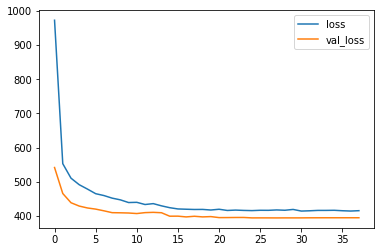

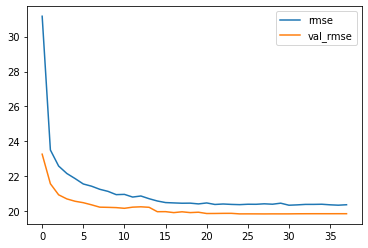

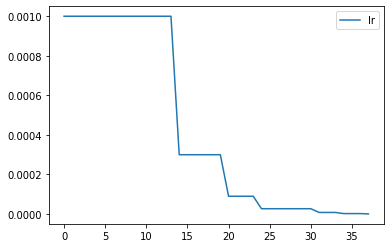

In [50]:
for metrics in [("loss", "val_loss"), ("rmse", "val_rmse"), ["lr"]]:
  pd.DataFrame(history.history, columns=metrics).plot()
  plt.show()

In [52]:
loss, rmse = model.evaluate(test_ds)
print('Testing RMSE is:', rmse)

16/16 [==============================] - 986s 61s/step - loss: 429.0410 - rmse: 20.6905
Testing RMSE is: 20.690507888793945


In [139]:
reduce_lr_2 = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.3,
    patience=3, 
    min_lr=1e-10
)

callbacks_2 = [checkpoint, reduce_lr_2]

optimizer = tf.keras.optimizers.Adam(1e-3)

model_2 = get_model()
model_2.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [140]:
history_2 = model_2.fit(train_ds, epochs=100, validation_data=val_ds, callbacks= callbacks_2)

Epoch 1/100
14/14 [==============================] - 25s 2s/step - loss: 797.5804 - rmse: 28.2271 - val_loss: 542.1328 - val_rmse: 23.2670 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 21s 2s/step - loss: 605.7670 - rmse: 24.5969 - val_loss: 502.6592 - val_rmse: 22.4036 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 21s 2s/step - loss: 550.1663 - rmse: 23.4404 - val_loss: 478.6661 - val_rmse: 21.8626 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 21s 2s/step - loss: 542.8387 - rmse: 23.2844 - val_loss: 465.8178 - val_rmse: 21.5675 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 21s 2s/step - loss: 530.4183 - rmse: 23.0168 - val_loss: 455.9398 - val_rmse: 21.3379 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 21s 2s/step - loss: 515.8260 - rmse: 22.6981 - val_loss: 448.8590 - val_rmse: 21.1718 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 21s 2s/step - loss: 506.3887 - rmse

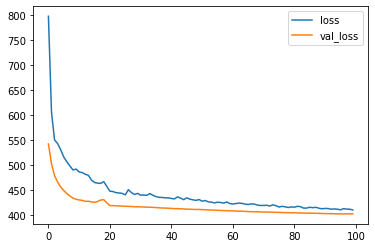

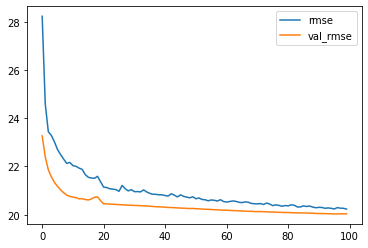

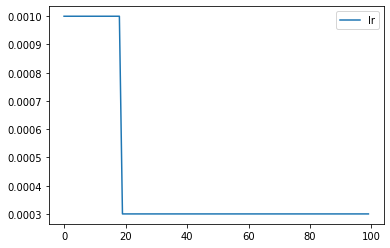

In [141]:
for metrics in [("loss", "val_loss"), ("rmse", "val_rmse"), ["lr"]]:
  pd.DataFrame(history_2.history, columns=metrics).plot()
  plt.show()

In [143]:
loss, rmse = model_2.evaluate(test_ds)
print('Testing RMSE is:', rmse)

4/4 [==============================] - 15s 4s/step - loss: 431.6012 - rmse: 20.7521
Testing RMSE is: 20.75208282470703


In [144]:
model_2.save('/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score/HJ_model_2.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
